## Testing for a relationship between physical distance and statistical dependence

> Q: Is there an (inverse) relationship between physical distance and correlation in neural activity?

\begin{align*}
    \rho_{ij} \propto \frac{1}{f(d_{ij})}
\end{align*}

where $\rho_{ij}$ is the correlation between the activity patterns of neurons $i$ and $j$, $d_{ij}$ is the physical or spatial distance between neuron $i$ and $j$ in the brain and $f(.)$ is some function of distance.

In this notebook, we test for the presence and nature of this relation through an ANOVA (parametric) test.

In [14]:
'''
Dependencies
'''
# General
from sklearn.decomposition import PCA
from tqdm.auto import tqdm
import scipy.io as sio
import pandas as pd
import numpy as np
import scipy
import random
import sys
import warnings 
from scipy import stats
warnings.simplefilter('ignore')
import statsmodels.api as sm
from tqdm import tqdm as pbar

# Utils and specific functions
from pyaldata import * 
sys.path.insert(0, '..') # rutils is in main folder directory
from rutils import *

# Plotting
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set_style('white')
cc = ['#416ae6', '#F25346', '#31AD6F', '#7FB8DA', '#6A695B', '#2A3146']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cc)
# green to blue ccycle
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#74E6A0', '#5FC49C', '#4AA298', '#348093', '#1F5E8F', '#0A3C8B'])

'''
Magic commands
'''
%config InlineBackend.figure_format = 'retina'

In [15]:
'''
Sessions. Note that VR sessions have typically more neurons than CF sessions
'''

sessions_vr = [
 'Chewie_CO_VR_2016-09-09.mat', # File Matt used to generate initial figures
 'Chewie_CO_VR_2016-09-12.mat',
 'Chewie_CO_VR_2016-09-14.mat',
 'Chewie_CO_VR_2016-10-06.mat',
 'Mihili_CO_VR_2014-03-03.mat',
 'Mihili_CO_VR_2014-03-04.mat',
 'Mihili_CO_VR_2014-03-06.mat',
]

sessions_cf = [
    'Chewie_CO_FF_2016-09-15.mat',
    'Chewie_CO_FF_2016-09-21.mat',
    'Chewie_CO_FF_2016-10-05.mat',
    'Chewie_CO_FF_2016-10-07.mat',
    'Mihili_CO_FF_2014-02-03.mat',
    'Mihili_CO_FF_2014-02-17.mat',
    'Mihili_CO_FF_2014-02-18.mat',
    'Mihili_CO_FF_2014-03-07.mat'
]

'''
Load electrode maps.
'''
m1_emap  = localize_elecs(read_cmp(file_path='/Users/Daphne/Data/Chewie Left M1 SN 6250-001474.cmp'), elecs=range(1,97))
pmd_emap = localize_elecs(read_cmp(file_path='/Users/Daphne/Data/Chewie Left PMd SN 6251-001469.cmp'), elecs=range(1,97))

np.random.seed(2021)

# Control number 3: randomize the electrode positions
m1_emap_rand = np.random.permutation(m1_emap.flat).reshape(10,10)
pmd_emap_rand = np.random.permutation(pmd_emap.flat).reshape(10,10)

In [16]:
'''
Pick a session and load in as pandas dataframe
'''

session = sessions_vr[0]
df = mat2dataframe('/Users/Daphne/Data/' + session, shift_idx_fields=True)
s_monkey = session[:1]

print(f'\n Selected session: {session} \n')


 Selected session: Chewie_CO_VR_2016-09-09.mat 



## 1 Preprocess

### 1.1 Preprocess spiking data 

First, we preprocess the trial data. Note that changing the parameters here will influence the results. 

In [17]:
warnings.filterwarnings('ignore')

# Combine bins 
td = combine_time_bins(df, n_bins=3)

# Remove low firing neurons
td = remove_low_firing_neurons(td, signal='M1_spikes',  threshold=1)
td = remove_low_firing_neurons(td, signal='PMd_spikes', threshold=1)

# Sqrt transform neurons
td = transform_signal(td, signals='M1_spikes',  transformations='sqrt')
td = transform_signal(td, signals='PMd_spikes', transformations='sqrt')

# Merge signals
td = merge_signals(td, ['M1_spikes', 'PMd_spikes'], 'both_spikes')

# Calculate firing rates from spikes, works on '_spikes' fields and automatically divides by bin_size
td = add_firing_rates(td, 'smooth', std=0.05)

# Select only baseline (BL) trials
td = td.loc[td['epoch'] == 'BL']

# # Export preprocessed data
# td.to_pickle(f'td_{session[:-4]}.pkl')

print(f'Number of neurons before processing: {df.M1_spikes[0].shape[1]+ df.PMd_spikes[0].shape[1]} \
      => After processing: {td.M1_spikes[0].shape[1]+ td.PMd_spikes[0].shape[1]} (M1: {td.M1_spikes[0].shape[1]}, PMd: {td.PMd_spikes[0].shape[1]})')

Number of neurons before processing: 246       => After processing: 218 (M1: 51, PMd: 167)


### 1.2 Trial-concatenate data 

Concatenate all trials to get an $N \times (T \times P)$ matrix $\mathbf{X}$

In [18]:
# This is the trial-concatenated data on which we will perform dimensionality reduction
X_concat = np.concatenate(td['both_rates'].values, axis=0).T

X_concat.shape # (neurons x timepoints)

(218, 27531)

### 1.3 Generate control data 

Shuffle the data row and column wise to break neuron and time correlations. We do:
- Shuffle along the neuron dimension (rows)
- Shuffle along the time dimension (columns)

In [19]:
rand_row_idx = random.sample(range(X_concat.shape[0]), X_concat.shape[0])
rand_col_idx = random.sample(range(X_concat.shape[1]), X_concat.shape[1])

# Randomize the rows of the data matrix
X_con_neurons = X_concat[rand_row_idx, :]

# Randomize the columns of the data matrix
X_con_time = X_concat[:, rand_col_idx]

# Both
#X_con_complete = X_rand_neurons[:, rand_col_idx]

## 2 Perform dimensionality reduction (PCA)

- Apply dimensionality reduction to the pooled (M1 + PMd) time series $\mathbf{X}_\text{emp}$
- Apply dimensionality reduction to data that was shuffled along the time dimension $\mathbf{X}_{\text{control-time}}$ (**Control 1**)
- Apply dimensionality reduction to data that was shuffled along the neuron dimension $\mathbf{X}_{\text{control-neurons}}$ (**Control 2**)

In [20]:
# Total neurons on both arrays together
N_total = td.both_rates[0].shape[1]

# Perform PCA on the trial concatenated trialdata
td, model_m1pmd = tools.dim_reduce(td, PCA(n_components=N_total), 'both_rates', 'both_pca', return_model=True)
m1pmd_pcs = model_m1pmd.components_.T

In [21]:
# Control
model_con_neurons = PCA(n_components=N_total)
model_con_neurons.fit(X_con_neurons.T);
pcs_con_neurons = model_con_neurons.components_.T

model_con_time = PCA(n_components=N_total)
model_con_time.fit(X_con_time.T);
pcs_con_time = model_con_time.components_.T

In [22]:
# fig, axs = plt.subplots(3, 2, figsize=(16, 12))

# axs[0, 0].set_title(r'$\mathbf{X}_{emp}$', y=1.01)
# axs[0, 0].plot(model_m1pmd.explained_variance_ratio_.cumsum(), '.-')
# axs[0, 0].set_ylabel('explained variance')

# axs[0, 1].bar(range(len(model_m1pmd.explained_variance_ratio_)), model_m1pmd.explained_variance_ratio_)

# axs[1, 0].set_title(r'$\mathbf{X}_{control-time}$', y=1.01)
# axs[1, 0].plot(model_con_time.explained_variance_ratio_.cumsum(), '.-')
# axs[1, 0].set_xlabel('PC')
# axs[1, 0].set_ylabel('explained variance')

# axs[1, 1].bar(range(len(model_con_time.explained_variance_ratio_)), model_con_time.explained_variance_ratio_)

# axs[2, 0].set_title(r'$\mathbf{X}_{control-neurons}$', y=1.01)
# axs[2, 0].plot(model_con_neurons.explained_variance_ratio_.cumsum(), '.-')
# axs[2, 0].set_xlabel('PC')
# axs[2, 0].set_ylabel('explained variance')

# axs[2, 1].bar(range(len(model_con_neurons.explained_variance_ratio_)), model_con_neurons.explained_variance_ratio_)
# axs[2, 1].set_xlabel('PC')

# fig.tight_layout()
# sns.despine()

## 3 Run ANOVA test for one sessions, given $K$ columns of the PC matrix

### 3.1 Choose the first $K$ PCs 

- Based on a threshold over the explained variance, we choose the number of PCs to work with

In [23]:
''' Choose level of variance explained '''
exp_var_level = 0.5

''' Parameters '''
OTHER_ARRAY_D = 50 # Distance value to indicate other array

# Select number of PCs required to explain X % of variance
K = np.argmax(model_m1pmd.explained_variance_ratio_.cumsum() > exp_var_level)

# Take the first K PCs of empirical data (K-dim Manifold)
L_emp = m1pmd_pcs[:, :K]

# (Control 1) Take the first K PCs of neuron dim control 
L_control_n = pcs_con_neurons[:, :K]

# (Control 2) Take the first K PCs of time dim control 
L_control_t = pcs_con_time[:, :K]

L_emp.shape # Neurons x K

(218, 19)

### 3.2 Compute Pearson correlation $\rho_{ij}$ and spatial distance $d_{ij}$ between neuron pairs


In [24]:
''' Compute correlations for true data (emp) and three controls '''

# True data
C_emp, D_emp, A_emp = corrs_and_distances(L_emp, td['M1_unit_guide'][0], td['PMd_unit_guide'][0], m1_emap, pmd_emap)

# (1) Control by shuffling along neuron dimension (rows)
C_control_n, D_control_n, A_control_n = corrs_and_distances(L_control_n, td['M1_unit_guide'][0], td['PMd_unit_guide'][0], m1_emap, pmd_emap)

# (2) Control by shuffling along time dimension (cols)
C_control_t, D_control_t, A_control_t = corrs_and_distances(L_control_t, td['M1_unit_guide'][0], td['PMd_unit_guide'][0], m1_emap, pmd_emap)

# (3) Control by shuffling electrode positions
C_rand_epos, D_rand_epos, A_rand_epos = corrs_and_distances(L_emp, td['M1_unit_guide'][0], td['PMd_unit_guide'][0], m1_emap_rand, pmd_emap_rand)

In [ ]:
# Sanity check
print(f'Percentage of correlations that changed: {100 - sum(C_emp == C_rand_epos) / len(C_emp) * 100:.2f}%.')
print(f'Percentage of distances that changed: {100 - sum(D_emp == D_rand_epos) / len(D_emp) * 100:.2f}%.')
#print(f'Percentage of distances that changed: {100 - sum(C_emp == C_control_n) / len(C_emp) * 100:.2f}%.')

### 3.3 Visualize distributions

#### Make 3 categories (same electrode, same array, other array) &  make intervals within same array category

In [ ]:
df_emp = pd.DataFrame(data={'correlation': C_emp, 'abs correlation': abs(C_emp), 'distance': D_emp, 'on array': A_emp})
df_emp['category'] = df_emp['distance'].apply(lambda d: 'same electrode' if d == 0 else ('same array' if d < OTHER_ARRAY_D else ('other array')))
df_emp['within distance'] = pd.cut(df_emp['distance'], bins=[-0.1, 0.001, 2.01, 4.01, OTHER_ARRAY_D], labels=['0', '(0, 2]','(2, 4]', '(4, inf)'])

# Indicator for when concatenating data
df_emp['Type'] = 'Actual'

In [ ]:
# Control (1) neuron dim
df_control_n = pd.DataFrame(data={'correlation': C_control_n, 'abs correlation': abs(C_control_n), 'distance': D_control_n, 'on array': A_control_n})
df_control_n['category'] = df_control_n['distance'].apply(lambda d: 'same electrode' if d == 0 else ('same array' if d < OTHER_ARRAY_D else ('other array')))
df_control_n['within distance'] = pd.cut(df_control_n['distance'], bins=[-0.1, 0.001, 2.01, 4.01, OTHER_ARRAY_D], labels=['0', '(0, 2]','(2, 4]', '(4, inf)'])

# Indicator for when concatenating data
df_control_n['Type'] = 'Surrogate'

# Control (2) time dim
df_control_t = pd.DataFrame(data={'correlation': C_control_t, 'abs correlation': abs(C_control_t), 'distance': D_control_t, 'on array': A_control_t})
df_control_t['category'] = df_control_t['distance'].apply(lambda d: 'same electrode' if d == 0 else ('same array' if d < OTHER_ARRAY_D else ('other array')))
df_control_t['within distance'] = pd.cut(df_control_t['distance'], bins=[-0.1, 0.001, 2.01, 4.01, OTHER_ARRAY_D], labels=['0', '(0, 2]','(2, 4]', '(4, inf)'])

# Control (3) electrode posisions
df_control_epos = pd.DataFrame(data={'correlation': C_rand_epos, 'abs correlation': abs(C_rand_epos), 'distance': D_rand_epos, 'on array': A_rand_epos})
df_control_epos['category'] = df_control_epos['distance'].apply(lambda d: 'same electrode' if d == 0 else ('same array' if d < OTHER_ARRAY_D else ('other array')))
df_control_epos['within distance'] = pd.cut(df_control_epos['distance'], bins=[-0.1, 0.001, 2.01, 4.01, OTHER_ARRAY_D], labels=['0', '(0, 2]','(2, 4]', '(4, inf)'])

In [ ]:
# To visualize both distributions (control 1 and real) in one plot
df_emp_and_control = pd.concat([df_emp, df_control_n])

In [ ]:
df_emp_and_control.head()

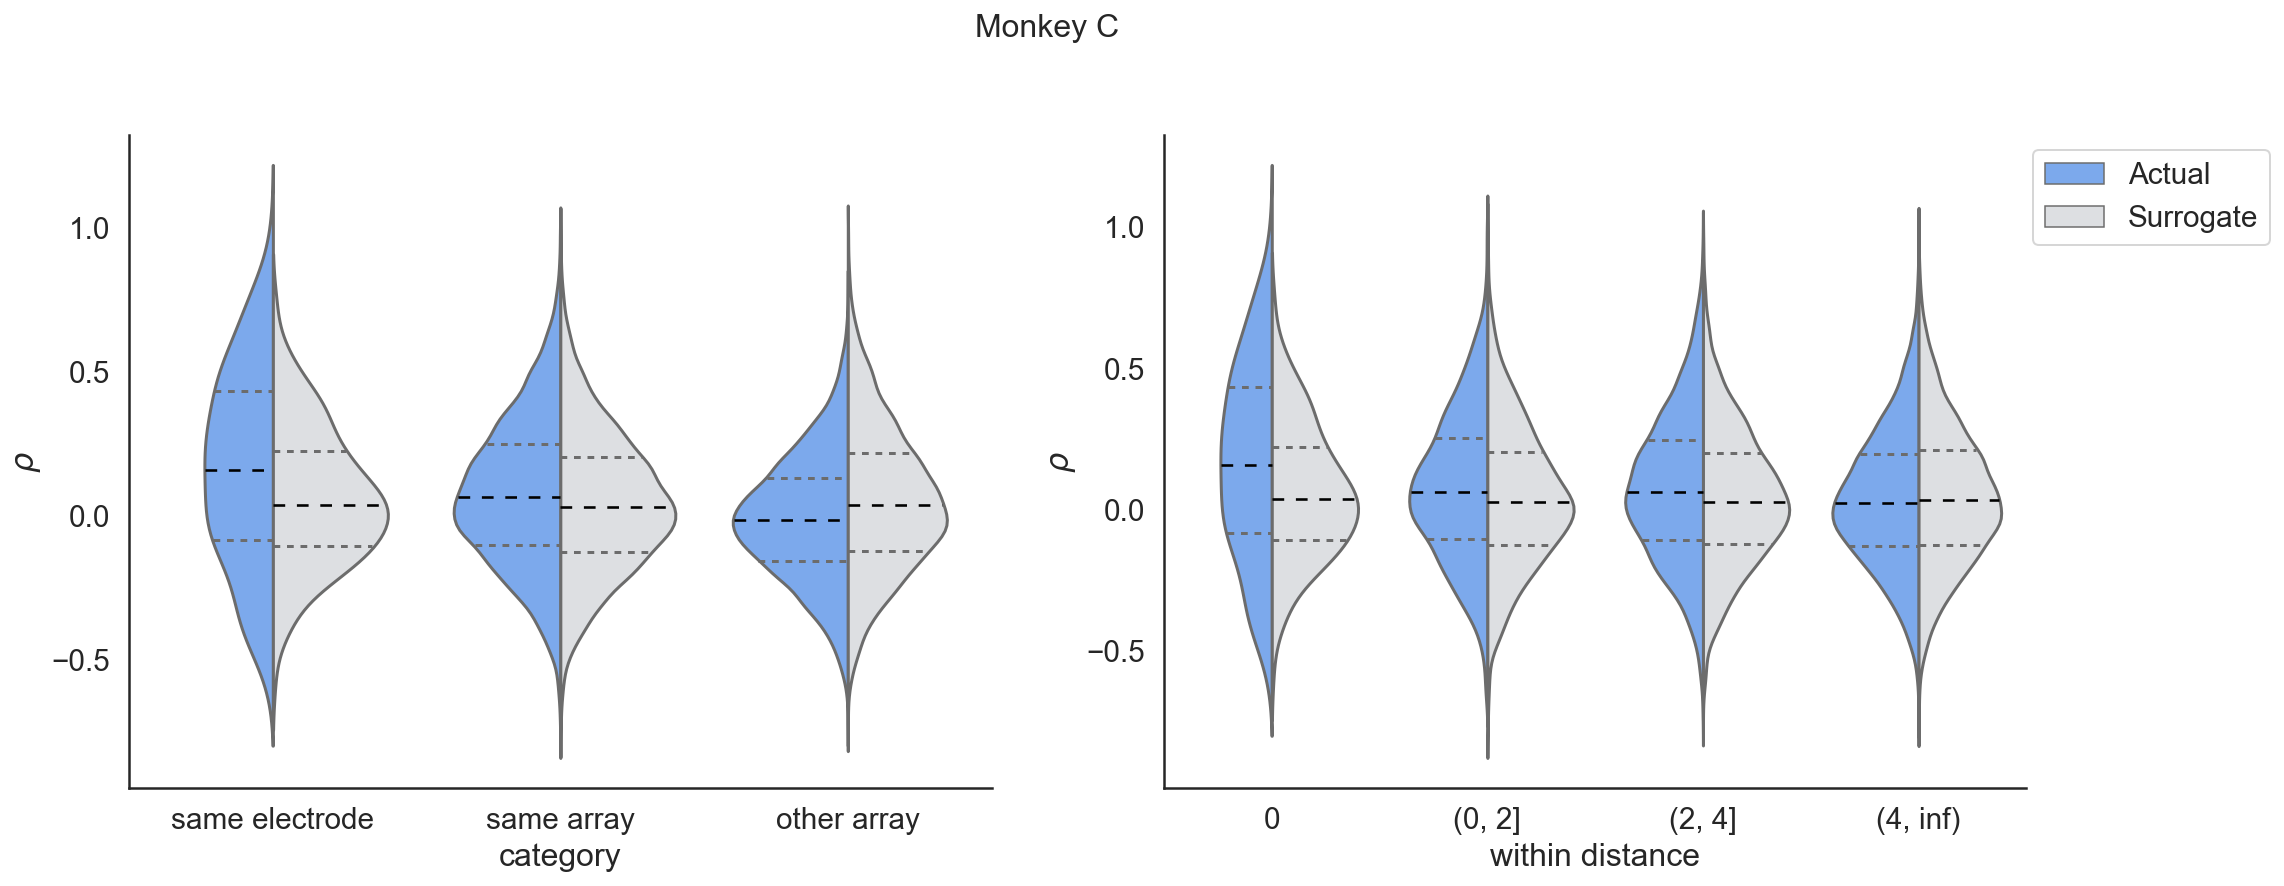

In [69]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#69A5FF', '#DCDFE3'])
plt.rcParams['axes.labelsize'] = 16

fig, axs = plt.subplots(1, 2, figsize=(17, 6))

fig.suptitle(f'Monkey {s_monkey}', y=1.02, fontsize=16)
sns.violinplot(x='category', y='correlation', hue='Type', data=df_emp_and_control, inner='quartile', 
            split=True, order=['same electrode', 'same array', 'other array'], legend=False, ax=axs[0])

sns.violinplot(x='within distance', y='correlation', hue='Type', data=df_emp_and_control, inner='quartile',
            split=True, order=['0', '(0, 2]','(2, 4]', '(4, inf)'], ax=axs[1], legend=True)

axs[0].set_ylim=(-1, 1.1)
axs[0].get_legend().remove()
axs[0].set_ylabel(r'$\rho$')
axs[1].set_ylim=(-1, 1.1)
axs[1].set_ylabel(r'$\rho$')
axs[1].legend(bbox_to_anchor=(1.3, 1))

# Make means different color
for l in axs[0].lines[1::3]:
    l.set_linewidth(1.3)
    l.set_color('#000000')
    
for l in axs[1].lines[1::3]:
    l.set_linewidth(1.3)
    l.set_color('#000000')

sns.despine()

In [70]:
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#69A5FF', '#DCDFE3'])
# plt.rcParams['axes.labelsize'] = 16

# g = sns.catplot(x='category', y='correlation', hue='Type', data=df_emp_and_control, kind='violin', inner='stick', 
#             split=True, order=['same electrode', 'same array', 'other array'], height=5.5, aspect=1.5, legend=True)
# g.fig.suptitle(f'Monkey {s_monkey}', y=1.02, fontsize=14)
# g.set(ylim=(-1, 1.1))
# g.set(ylabel=r'$\rho$')
# g.set(xlabel='');

In [71]:
# Check things
#df_emp.loc[df_emp['on array'] == 'OA', 'correlation'].mean()

### 3.3 Run ANOVA tests

In [84]:
p_vals_OA = []
p_vals_SA = []
p_vals_SE = []
coeffs = []

In [92]:
res.pvalues[0]

7.779819932251951e-10

In [10]:
intervals = [(0, 2), (0, 4)]

variants = {
  'Empirical study' : df_emp,
#   'Control study 1: shuffled neurons': df_control_n,
#   'Control study 2: shuffled time': df_control_t,
#   'Control study 3: shuffled electrodes' : df_control_epos,
}

int_dum = lambda df, lb, ub: df['distance'].apply(lambda x: 1 if lb < x <= ub else 0)
on_arr = lambda df, arr: df['on array'].apply(lambda x: 1 if x == arr else 0)
same_ele = lambda df: df['distance'].apply(lambda x: 1 if x == 0 else 0)
same_arr = lambda df: df['distance'].apply(lambda x: 1 if 0 < x < OTHER_ARRAY_D else 0)

analyses = {
  'single category' : {
    'fixed cols' : {
      'OA Constant' : lambda df: [1] * len(df),
      'SE (d = 0)' : same_ele,
      'SA (d exists)' : same_arr,
    },
    'variable cols' : {}
  },
  'multiple categories' : {
    'fixed cols' : {
      'M1 Constant' : lambda df: on_arr(df, 'M1'),
      'OA Constant' : lambda df: on_arr(df, 'OA'),
      'PMd Constant' : lambda df: on_arr(df, 'PMd'),
      'SE (d = 0)' : same_ele
    },
    'variable cols' : {
      'd in ' : lambda df, lb, ub: int_dum(df, lb, ub),
    },
  },
  'separate' : {
    'fixed cols' : {
      'M1 Constant' : lambda df: on_arr(df, 'M1'),
      'OA Constant' : lambda df: on_arr(df, 'OA'),
      'PMd Constant' : lambda df: on_arr(df, 'PMd'),
      'M1 SE (d = 0)' : lambda df: on_arr(df, 'M1') * same_ele(df),
      'PMd SE (d = 0)' : lambda df: on_arr(df, 'PMd') * same_ele(df),
    },
    'variable cols' : {
      'M1 d in ' : lambda df, lb, ub: int_dum(df, lb, ub) * on_arr(df, 'M1'),
      'PMd d in ' : lambda df, lb, ub: int_dum(df, lb, ub) * on_arr(df, 'PMd'),
    }
  },
}
res_dict = {}
for study, df in variants.items():
    for analysis, cols_dict in analyses.items():
        df_X = pd.DataFrame()
        for col_name, col_func in cols_dict['fixed cols'].items():
            df_X[col_name] = col_func(df)
        for (lb, ub) in intervals:
            for col_name, col_func in cols_dict['variable cols'].items():
                df_X[col_name + f'({lb:.1f}, {ub:.1f}]'] = col_func(df, lb, ub)
        df_X = df_X.reindex(sorted(df_X.columns), axis=1)
        res = sm.OLS(df.correlation, df_X, hasconst=True).fit()
        title = study + f' ({analysis})'
        print(res.summary(title=title, alpha=.05), end='\n\n\n\n')
        res_dict[title] = res

NameError: name 'df_emp' is not defined

### Make plots for range of PCs based on explained variance

In [20]:
# ''' Parameters '''
# OTHER_ARRAY_D = 50 # Distance value to indicate other array
# df_across_pcs = []

# ''' Choose level of variance explained '''
# exp_var_levels = np.arange(0.5, 0.85, 0.1)

# # Compute number of PCs that correspond to each level of explained variance
# k_range = [np.argmax(model_m1pmd.explained_variance_ratio_.cumsum() > exp_var_levels[i]) for i in range(len(exp_var_levels))]

# for it, K in pbar(enumerate(k_range)):
    
#     # (1) Take the first K PCs of empirical data (K-dim Manifold) and control (shuffled along neuron dim)
#     L_emp = m1pmd_pcs[:, :K]
#     L_control_n = pcs_con_neurons[:, :K]
    
#     # (2) Compute correlations between neuron pairs
#     C_emp, D_emp, A_emp = corrs_and_distances(L_emp, td['M1_unit_guide'][0], td['PMd_unit_guide'][0], m1_emap, pmd_emap)
#     C_control_n, D_control_n, A_control_n = corrs_and_distances(L_control_n, td['M1_unit_guide'][0], td['PMd_unit_guide'][0], m1_emap, pmd_emap)

#     # (3) Convert to dataframe and categorize based on spatial distance
#     df_emp = pd.DataFrame(data={'correlation': C_emp, 'abs correlation': abs(C_emp), 'distance': D_emp, 'on array': A_emp})
#     df_emp['category'] = df_emp['distance'].apply(lambda d: 'same electrode' if d == 0 else ('same array' if d < OTHER_ARRAY_D else ('other array')))
#     df_emp['within distance'] = pd.cut(df_emp['distance'], bins=[-0.1, 0.001, 2.01, 4.01, OTHER_ARRAY_D], labels=['0', '(0, 2]','(2, 4]', '(4, inf)'])
#     # Indicator for when concatenating data
#     df_emp['Type'] = 'Actual'
    
#     df_control_n = pd.DataFrame(data={'correlation': C_control_n, 'abs correlation': abs(C_control_n), 'distance': D_control_n, 'on array': A_control_n})
#     df_control_n['category'] = df_control_n['distance'].apply(lambda d: 'same electrode' if d == 0 else ('same array' if d < OTHER_ARRAY_D else ('other array')))
#     df_control_n['within distance'] = pd.cut(df_control_n['distance'], bins=[-0.1, 0.001, 2.01, 4.01, OTHER_ARRAY_D], labels=['0', '(0, 2]','(2, 4]', '(4, inf)'])
#     # Indicator for when concatenating data
#     df_control_n['Type'] = 'Surrogate'
    
#     # Concatenate dataframes
#     df_emp_and_control = pd.concat([df_emp, df_control_n])
    
#     # Store
#     df_across_pcs.append(df_emp_and_control)

In [ ]:
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#69A5FF', '#DCDFE3'])
# plt.rcParams['axes.labelsize'] = 16

# for i in range(len(df_across_pcs)):

#     g = sns.catplot(x='category', y='correlation', hue='Type', data=df_across_pcs[i], kind='violin', 
#                 split=True, order=['same electrode', 'same array', 'other array'], height=5.5, aspect=1.5, legend=True)
#     g.fig.suptitle(f'Monkey {s_monkey} - {exp_var_levels[i]*100}% variance explained [ PCs = {k_range[i]} ]', y=1.02, fontsize=14)
#     g.set(ylim=(-1, 1.1))
#     g.set(ylabel=r'$\rho$')
#     g.set(xlabel='');

In [ ]:
#print(res.summary().as_latex())

## 4 Run ANOVA tests for all sessions and across PCs

In [24]:
# exp_var_levels_str = ['40', '45', '50', '55', '60', '65', '70', '75', '80', '85']

# sns.set_theme(style='whitegrid')
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#FF4F4F', '#E3606C', '#C6718A', '#AA82A7', '#8D93C4', '#71A4E2', '#54B5FF'])
# plt.rcParams.update({'font.size': 15})

In [25]:
# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# fig.suptitle('OLS regression coefficients across sessions', y=1.02)

# axs[0].set_title(r'Same array coefficient: $\beta_1$', loc='left', fontsize=14)
# for i, s in enumerate(sessions_beta1): 
#     if i <= 6: axs[0].plot(s, 'o-', color='b', alpha=0.8)
#     else: axs[0].plot(s, 'o-', color='g', alpha=0.5)
# axs[0].set_xlabel('Percentage of explained variance')
# axs[0].set_xticklabels(exp_var_levels_str)
# axs[0].set_ylim([0, 0.45])

# axs[1].set_title(r'Same electrode coefficient: $\beta_2$', loc='left', fontsize=14)
# for i, s in enumerate(sessions_beta2): 
#     if i <= 6: axs[1].plot(s, 'o-', color='b', alpha=0.8) # Plot VR tasks in blue
#     else: axs[1].plot(s, 'o-', color='g', alpha=0.5) # CF tasks in green
# axs[1].set_xlabel('Percentage of explained variance')
# axs[1].set_xticklabels(exp_var_levels_str)
# axs[1].set_ylim([0, 0.45])

# legend_elements = [Patch(facecolor='b',label='VR task'), Patch(facecolor='g',label='CF task')]
# axs[1].legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.3, 0.9), fontsize=16)

# fig.tight_layout()

[Look at this](https://seaborn.pydata.org/tutorial/relational.html)